In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.preprocessing import TransactionEncoder

In [29]:
# Load the dataset
df = pd.read_csv(r'C:/Users/USER/Downloads/Groceries_dataset.csv/Groceries_dataset.csv')

In [30]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Exploratory Data Analysis (EDA)
print("Dataset Overview:")
print(df.head())

print("\nDataset Information:")
print(df.info())

Dataset Overview:
   Member_number       Date   itemDescription
0           2421 2015-11-21  abrasive cleaner
1           3390 2015-02-21  abrasive cleaner
2           2730 2015-06-15  abrasive cleaner
3           4808 2015-07-26  abrasive cleaner
4           4328 2015-02-04  abrasive cleaner

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Member_number    38765 non-null  int64         
 1   Date             38765 non-null  datetime64[ns]
 2   itemDescription  38765 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 908.7+ KB
None


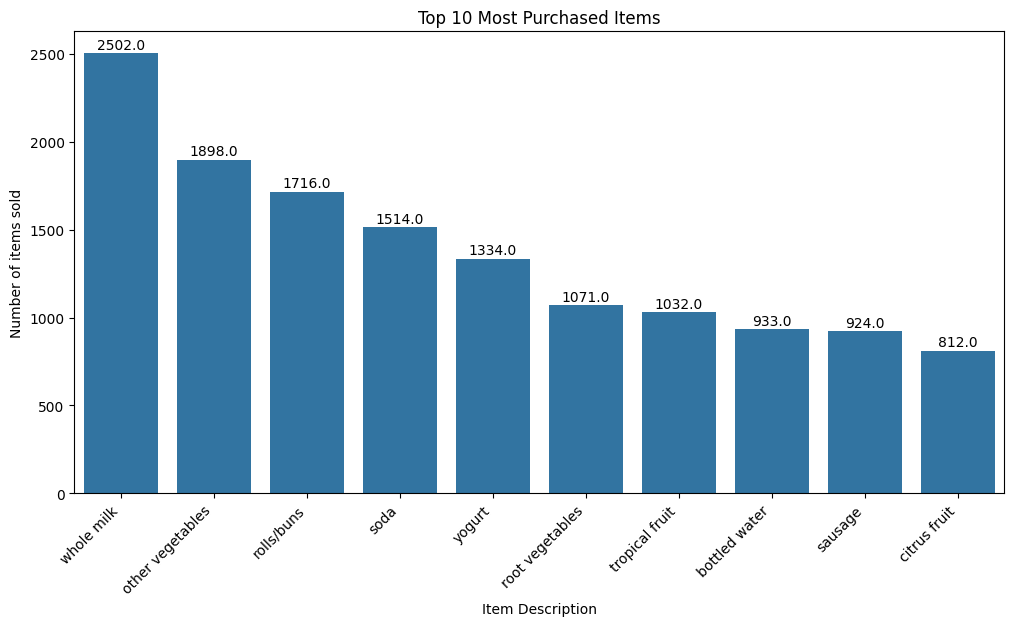

In [31]:
# Visualization 1: The most Purchased items
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='itemDescription', data=df, order=df['itemDescription'].value_counts().index[:10])

# Add labels on each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 6), textcoords='offset points')

plt.title('Top 10 Most Purchased Items')
plt.xlabel('Item Description')
plt.ylabel('Number of items sold')
plt.xticks(rotation=45, ha='right')
plt.show()



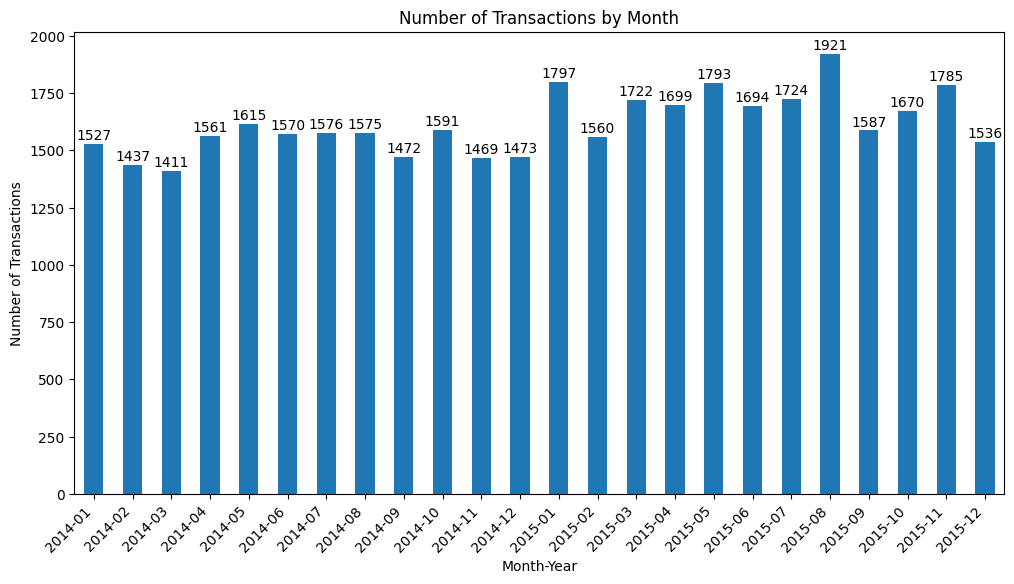

In [32]:
# Visualization 2: Number of transactions per month over the 2 years
plt.figure(figsize=(12, 6))

# Extract month and year from the 'Date' column
df['MonthYear'] = df['Date'].dt.to_period("M")

# Plot the number of transactions by month
ax = df['MonthYear'].value_counts().sort_index().plot(kind='bar')

# Add labels on each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 6), textcoords='offset points')

plt.title('Number of Transactions by Month')
plt.xlabel('Month-Year')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45, ha='right')

plt.show()


In [33]:
# Market Basket Analysis using FP-Growth
# Convert the dataset into a transaction format
transactions = df.groupby(['Member_number', 'Date'])['itemDescription'].apply(list).reset_index(name='items')

# Transform the data into a one-hot encoded format
te = TransactionEncoder()
te_ary = te.fit(transactions['items']).transform(transactions['items'])
sparse_df = pd.DataFrame(te_ary, columns=te.columns_)

In [34]:

# Run FP-Growth algorithm
frequent_itemsets = fpgrowth(sparse_df, min_support=0.001, use_colnames=True)


# Display the frequent itemsets
print("\nFrequent Itemsets:")
print(frequent_itemsets.sort_values(by='support', ascending=False).head(10))




Frequent Itemsets:
     support            itemsets
0   0.157923        (whole milk)
17  0.122101  (other vegetables)
11  0.110005        (rolls/buns)
6   0.097106              (soda)
3   0.085879            (yogurt)
26  0.069572   (root vegetables)
20  0.067767    (tropical fruit)
38  0.060683     (bottled water)
4   0.060349           (sausage)
62  0.053131      (citrus fruit)


In [35]:
# Generate association rules
from mlxtend.frequent_patterns import association_rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.001)

# Display the association rules
print("\nAssociation Rules:")
print(rules.sort_values(by='confidence', ascending=False).head(10))


Association Rules:
                antecedents   consequents  antecedent support  \
74        (sausage, yogurt)  (whole milk)            0.005748   
80    (sausage, rolls/buns)  (whole milk)            0.005347   
86          (sausage, soda)  (whole milk)            0.005948   
92    (semi-finished bread)  (whole milk)            0.009490   
52     (rolls/buns, yogurt)  (whole milk)            0.007819   
75    (sausage, whole milk)      (yogurt)            0.008955   
496             (detergent)  (whole milk)            0.008621   
1152                  (ham)  (whole milk)            0.017109   
638          (bottled beer)  (whole milk)            0.045312   
552           (frozen fish)  (whole milk)            0.006817   

      consequent support   support  confidence      lift  leverage  \
74              0.157923  0.001470    0.255814  1.619866  0.000563   
80              0.157923  0.001136    0.212500  1.345594  0.000292   
86              0.157923  0.001069    0.179775  1.1383

In [41]:
# Identify the top 20 combinations
top_combinations = rules.sort_values(by='support', ascending=False).head(20)

# Deduplicate based on the sorted frozensets of antecedents and consequents
top_combinations['sorted_antecedents'] = top_combinations['antecedents'].apply(lambda x: frozenset(sorted(x)))
top_combinations['sorted_consequents'] = top_combinations['consequents'].apply(lambda x: frozenset(sorted(x)))

# Function to check if two combinations are the same regardless of order
def are_combinations_equal(comb1, comb2):
    return (comb1['sorted_antecedents'] == comb2['sorted_consequents']) and (comb1['sorted_consequents'] == comb2['sorted_antecedents'])

# Deduplicate using the function
unique_combinations = [top_combinations.iloc[0].copy()]

for i in range(1, len(top_combinations)):
    current_comb = top_combinations.iloc[i].copy()  # Make a copy to avoid SettingWithCopyWarning
    is_duplicate = False

    for unique_comb in unique_combinations:
        if are_combinations_equal(current_comb, unique_comb):
            is_duplicate = True
            unique_comb['support'] += current_comb['support']  # Add up the support
            unique_comb['confidence'] = max(unique_comb['confidence'], current_comb['confidence'])  # Keep the higher confidence

    if not is_duplicate:
        unique_combinations.append(current_comb)

# Create a new column for simplified labels
for combo in unique_combinations:
    combo['combined_labels'] = ', '.join(map(str, combo['antecedents'] | combo['consequents']))

# Display the unique combinations
unique_combinations_df = pd.DataFrame(unique_combinations)
print("\nTop Unique Combinations:")
print(unique_combinations_df[['combined_labels', 'support', 'confidence']])



Top Unique Combinations:
                  combined_labels   support  confidence
353  other vegetables, whole milk  0.029673    0.121511
171        rolls/buns, whole milk  0.027936    0.126974
97               soda, whole milk  0.023257    0.119752
38             yogurt, whole milk  0.022322    0.129961
173  rolls/buns, other vegetables  0.021119    0.095990
98         other vegetables, soda  0.019381    0.099794
59            sausage, whole milk  0.017911    0.148394
422    tropical fruit, whole milk  0.016441    0.121302
101              rolls/buns, soda  0.016173    0.083276
42       other vegetables, yogurt  0.016173    0.094163


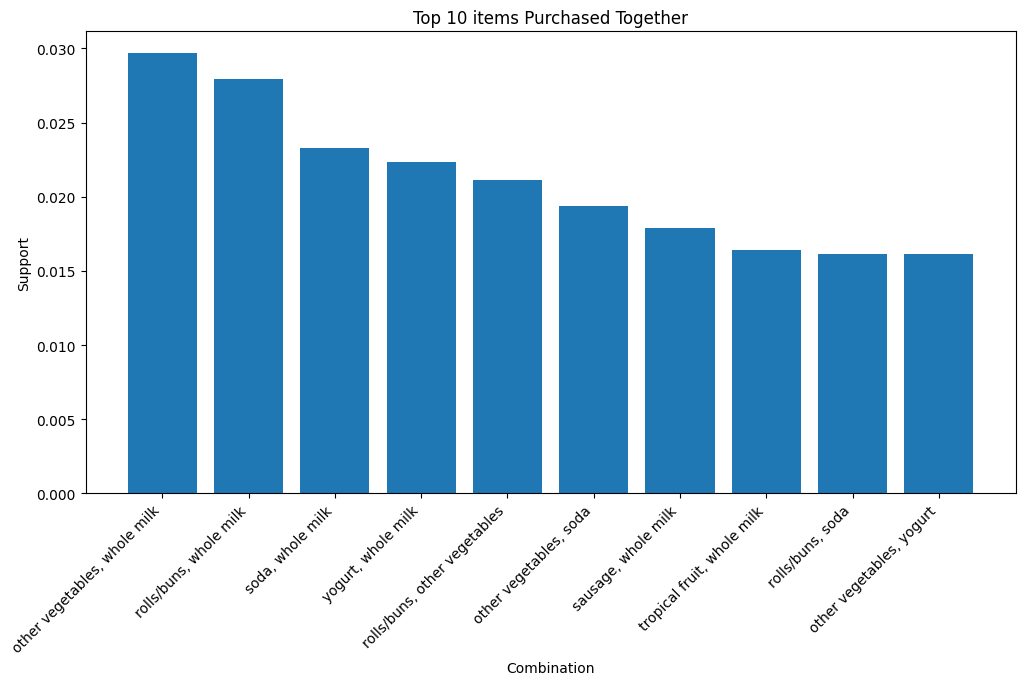

In [42]:
# Visualize the unique combinations
plt.figure(figsize=(12, 6))
plt.bar(range(len(unique_combinations_df)), unique_combinations_df['support'], tick_label=unique_combinations_df['combined_labels'])
plt.title('Top 10 items Purchased Together')
plt.xlabel('Combination')
plt.ylabel('Support')
plt.xticks(rotation=45, ha='right')
plt.show()
